# Main Functions and Goals: 
### 1.Set up a daily-scheduled mission to scrape currency rate data of USD, CNY and JYD vs TWD
### 2. insert scraped data into MySQL Database
### 3. set up a post  api  on django server for further usage

## Library Needed listed as below

In [2]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import mysql.connector

## Part1: Data Scraping and MySQL Data Insert

In [13]:
class currency_crawler(object):
    def __init__(self,start_date,end_date):
        self.info_dict={'日圓':['JPY','日圓(JPY)'],'美元':['USD','美元(USD)'],'人民幣':['CNY','人民幣(CNY)']}
        self.start_date=start_date
        self.end_date=end_date
    def item_filter(self,x):
                if (type(x)==int) or (type(x)==float and (str(x)!='nan')):
                    return x
                elif type(x)==pd._libs.tslibs.timestamps.Timestamp:
                    return str(x)
                elif (type(x)==dict) or (type(x)==list):
                    return json.dumps(x)
                elif ((type(x)==float) and (str(x)=='nan')) or ((type(x)==pd._libs.tslibs.nattype.NaTType) and (str(x)=='NaT')):
                    return None         
                else: return x
    def downloader(self,currency,transfer_to_db=False):
        mydb = mysql.connector.connect(
                host=data['host'],
                user=data['user'],
                passwd=data['passwd'],
                port=data['port'],
                database=data['database']
                )
        cnx=mydb.cursor()
        
        cnx.execute('select * from currency_rate where time=%s and currency=%s',[self.start_date,self.info_dict[currency][0]])
        
        if len(cnx.fetchall())>0:
            # do not insert repeated data
            print('data already exists')
            
            mydb.close()
        
        else:
        
            try:

                payload={'data':{"Currency":self.info_dict[currency][0],"Currencytype":"1","Rangetype":"3","Startdate":self.start_date,"Enddate":self.end_date,"CurrencyTitle":self.info_dict[currency][1]}}

                headers={
                'Referer': 'https://www.esunbank.com.tw/bank/personal/deposit/rate/forex/exchange-rate-chart?Currency=%s/TWD'%self.info_dict[currency][0],
                }
                with requests.Session() as s:
                    r=s.post('https://www.esunbank.com.tw/bank/Layouts/esunbank/Deposit/DpService.aspx/GetLineChartJson',json=payload,headers=headers)
                info=r.json()
                l=[]
                columns=['Time','Currency','BuyRate','SellRate']
                for item in json.loads(info['d'])['Rates']:
                    l.append([datetime.strptime(item[columns[0]], '%Y-%m-%d'),self.info_dict[currency][0],item[columns[2]],item[columns[3]]])
                df=pd.DataFrame(l,columns=columns)

                if (len(df)>0) & (transfer_to_db==True):

                    records_to_insert=[[self.item_filter(a) for a in x] for x in df.values.tolist()]

                    mySql_insert_query='''insert into currency_rate ({}) values ({})'''.format(','.join(columns),','.join('%s' for _ in range(len(columns))))

                    cnx.executemany(mySql_insert_query, records_to_insert)

                    mydb.commit()
                    
                    print('data of %s from %s to %s inserted successfully'%(currency,start_date,end_date))
                    

                else:
                    if len(df)==0:
                        print('No data Captured!')
                    pass
                mydb.close()
            except Exception as  E:
                print(E)
                try:
                    mydb.close()
                except:
                    pass
        

In [ ]:
#use calendar to check the day is on weekday or weekend and only start scraping process on weekday
if __name__=='__main__':
    td=datetime.now().date()-timedelta(days=0)
    wd=calendar.day_name[td.weekday()]
    #weekend
    if td.weekday() in [5,6]:

        print('Today is %s %s on weekend. Thus, pass this round'%(td,wd))
        pass
    #weekday
    else:
        if td.weekday()==0:
            delay=3
        else:
            delay=1
        start_date=end_date=str(td-timedelta(days=delay))
        print('Today is %s %s. Thus,start_date & end_date = %s %s'%(td,wd,start_date,calendar.day_name[(td-timedelta(days=delay)).weekday()]))
        
        C=currency_crawler(start_date,end_date)
        for dollar in ['日圓','人民幣','美元']:
            C.downloader(dollar,True)

## Part2: Set up RESTful API on Django Server

In [ ]:
def welcome(request):
    try:
        if 'data' in request.POST:
            ds=eval(request.POST['data'])
            if sorted(ds.keys())==sorted(['currency','start_date','end_date']):
                print(type(request.POST['data']))
                with open('db_connect.json','r') as f:
                    data=json.load(f)
                
                mydb = mysql.connector.connect(
                host=data['host'],
                user=data['user'],
                passwd=data['passwd'],
                port=data['port'],
                database=data['database']
                )
                cnx=mydb.cursor()
                cnx.execute('select * from currency_rate where Time between %s and %s  and Currency=%s',[ds['start_date'],ds['end_date'],ds['currency']])
                ls=cnx.fetchall()
                mydb.close()
                transfer={}
                for item in ls:
                    transfer.update({str(item[0].date()):{'Currency':item[1],'BuyRate':float(item[2]),'SellRate':float(item[3])}})
                #Return data as json format 
                return HttpResponse(json.dumps(transfer), content_type='application/json')
            else:
                return HttpResponse(status=403)

            
        else:
            return HttpResponse(status=403)
    except Exception as E:
        print(E)
        try:
            mydb.close()
        except:
            pass
        return HttpResponse(status=403)

## Part3: Retrieve Data  from Django Server via RESTful API

JPY
BuyRate     0.2705
SellRate    0.2745
Name: 2020-01-13, dtype: object


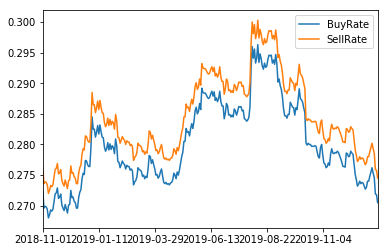

USD
BuyRate     29.89
SellRate    29.99
Name: 2020-01-13, dtype: object


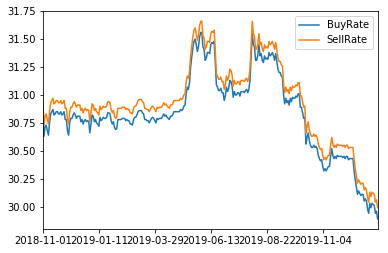

CNY
BuyRate     4.32
SellRate    4.37
Name: 2020-01-13, dtype: object


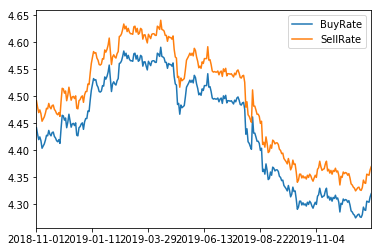

In [23]:
for cr in ['JPY','USD','CNY']:
    data=json.dumps({"currency": cr, "end_date": "%s"%datetime.now().date(), "start_date": "2018-11-01"})
    payload={'csrfmiddlewaretoken': 'QR6P3Hrs1991vPljBi2TCz33y1rucCjnz8nSRiQKbIRwAzU4pw1iuE3BahoxpCjr','data':data}
    headers={
    'Cookie': 'csrftoken=kmKC4dPs6Y0rq7iTMNV9hOWcUlvev2Cu3D1FSOeKgxIWvRREA1Uy9TWKwBshI2Cy',
    }
    r=requests.post(my_api_address,data=payload,headers=headers)
#     print(r)
    df=pd.DataFrame(r.json()).transpose()[['BuyRate','SellRate']].reset_index().sort_values(by='index').set_index('index')
    df.index.name=''
    print(cr)
    print(df.iloc[-1,:])
    df.plot()
    plt.show()   